# Economic Data Analysis with Fred & Pandas

In [1]:
!pip install fredapi > /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = 'e13a36efb5e28d626f5f0241662f0007'

# 1. Create the Fred Object

In [3]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [4]:
sp_search = fred.search('S&P',order_by='popularity')

In [5]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-07-26,2023-07-26,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-07-25,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-07-26 08:48:06-05:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-07-26,2023-07-26,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-05-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-07-25 08:11:01-05:00,91,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-07-26,2023-07-26,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-07-25,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-07-26 08:48:10-05:00,83,This data represents the effective yield of th...
SP500,SP500,2023-07-26,2023-07-26,S&P 500,2013-07-26,2023-07-25,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-07-25 19:10:48-05:00,82,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2023-07-26,2023-07-26,Real Median Household Income in the United States,1984-01-01,2021-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2022-09-13 13:48:01-05:00,81,Household data are collected as of March. As ...


# 3. Pull Raw Data & Plot

In [6]:
sp500 = fred.get_series(series_id='SP500')

<Axes: title={'center': 'S&P 500'}>

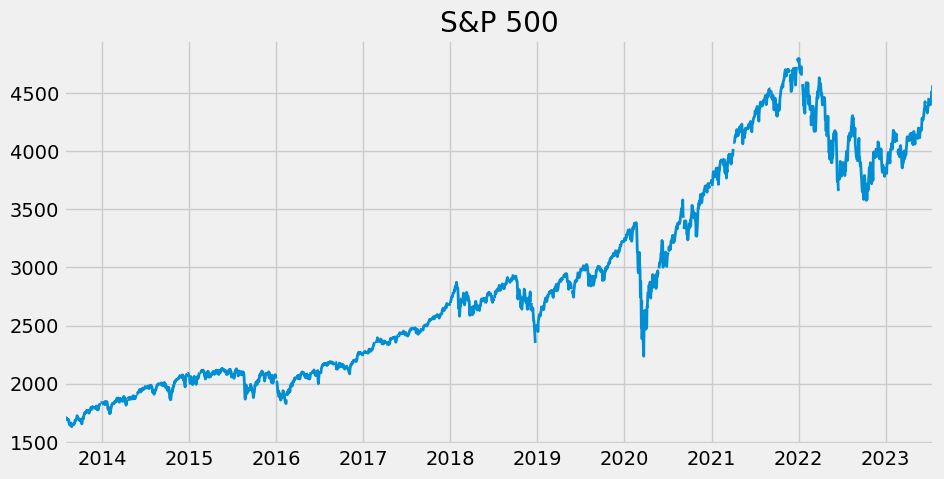

In [7]:
sp500.plot(figsize=(10,5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [8]:
unemployment_df = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))
unemployment_df = unemployment_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemployment_df = unemployment_df.loc[unemployment_df['title'].str.contains('Unemployment Rate in')]
unemployment_df = unemployment_df.loc[unemployment_df['id'].str.contains('R')]
unemployment_df = unemployment_df.loc[~unemployment_df['title'].str.contains('Census')]

 

In [9]:
all_results = []

for myid in unemployment_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemploymnet_states = pd.concat(all_results, axis=1)
id_to_state = unemployment_df['title'].str.replace('Unemployment Rate in','').to_dict()
unemploymnet_states.columns = [id_to_state[c] for c in unemploymnet_states.columns]

In [10]:
unemploymnet_states = unemploymnet_states.dropna()
unemploymnet_states = unemploymnet_states.drop(' Puerto Rico', axis=1)

In [11]:
# Plot States Unemploymnet Rate
px.line(unemploymnet_states)

## Pull April 2020 unemploymnet Rate per State

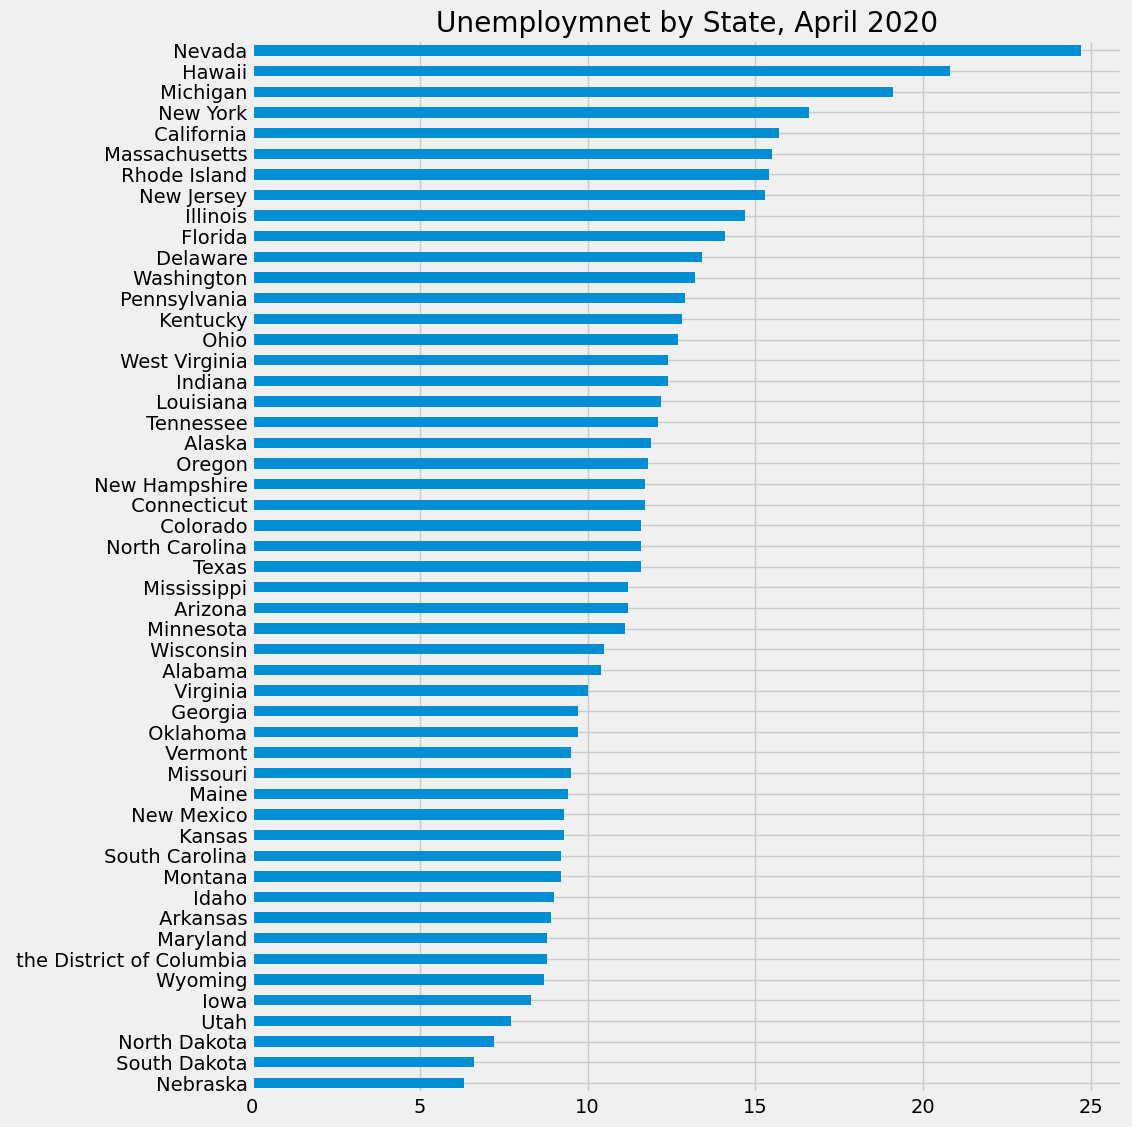

In [12]:
ax = unemploymnet_states.loc[unemploymnet_states.index == '2020-05-01'].T.sort_values('2020-05-01').plot(kind='barh', figsize=(10, 13), title='Unemploymnet by State, April 2020')

ax.legend().remove()

# Pull Participation Rate

In [13]:
part_df = fred.search('participation rate state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for')]

In [14]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for', '').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]


# Plot Unemployment vs Participation

In [15]:
# Fix DC
unemploymnet_states = unemploymnet_states.rename(columns={' the District of Columbia': ' District of Columbia'})

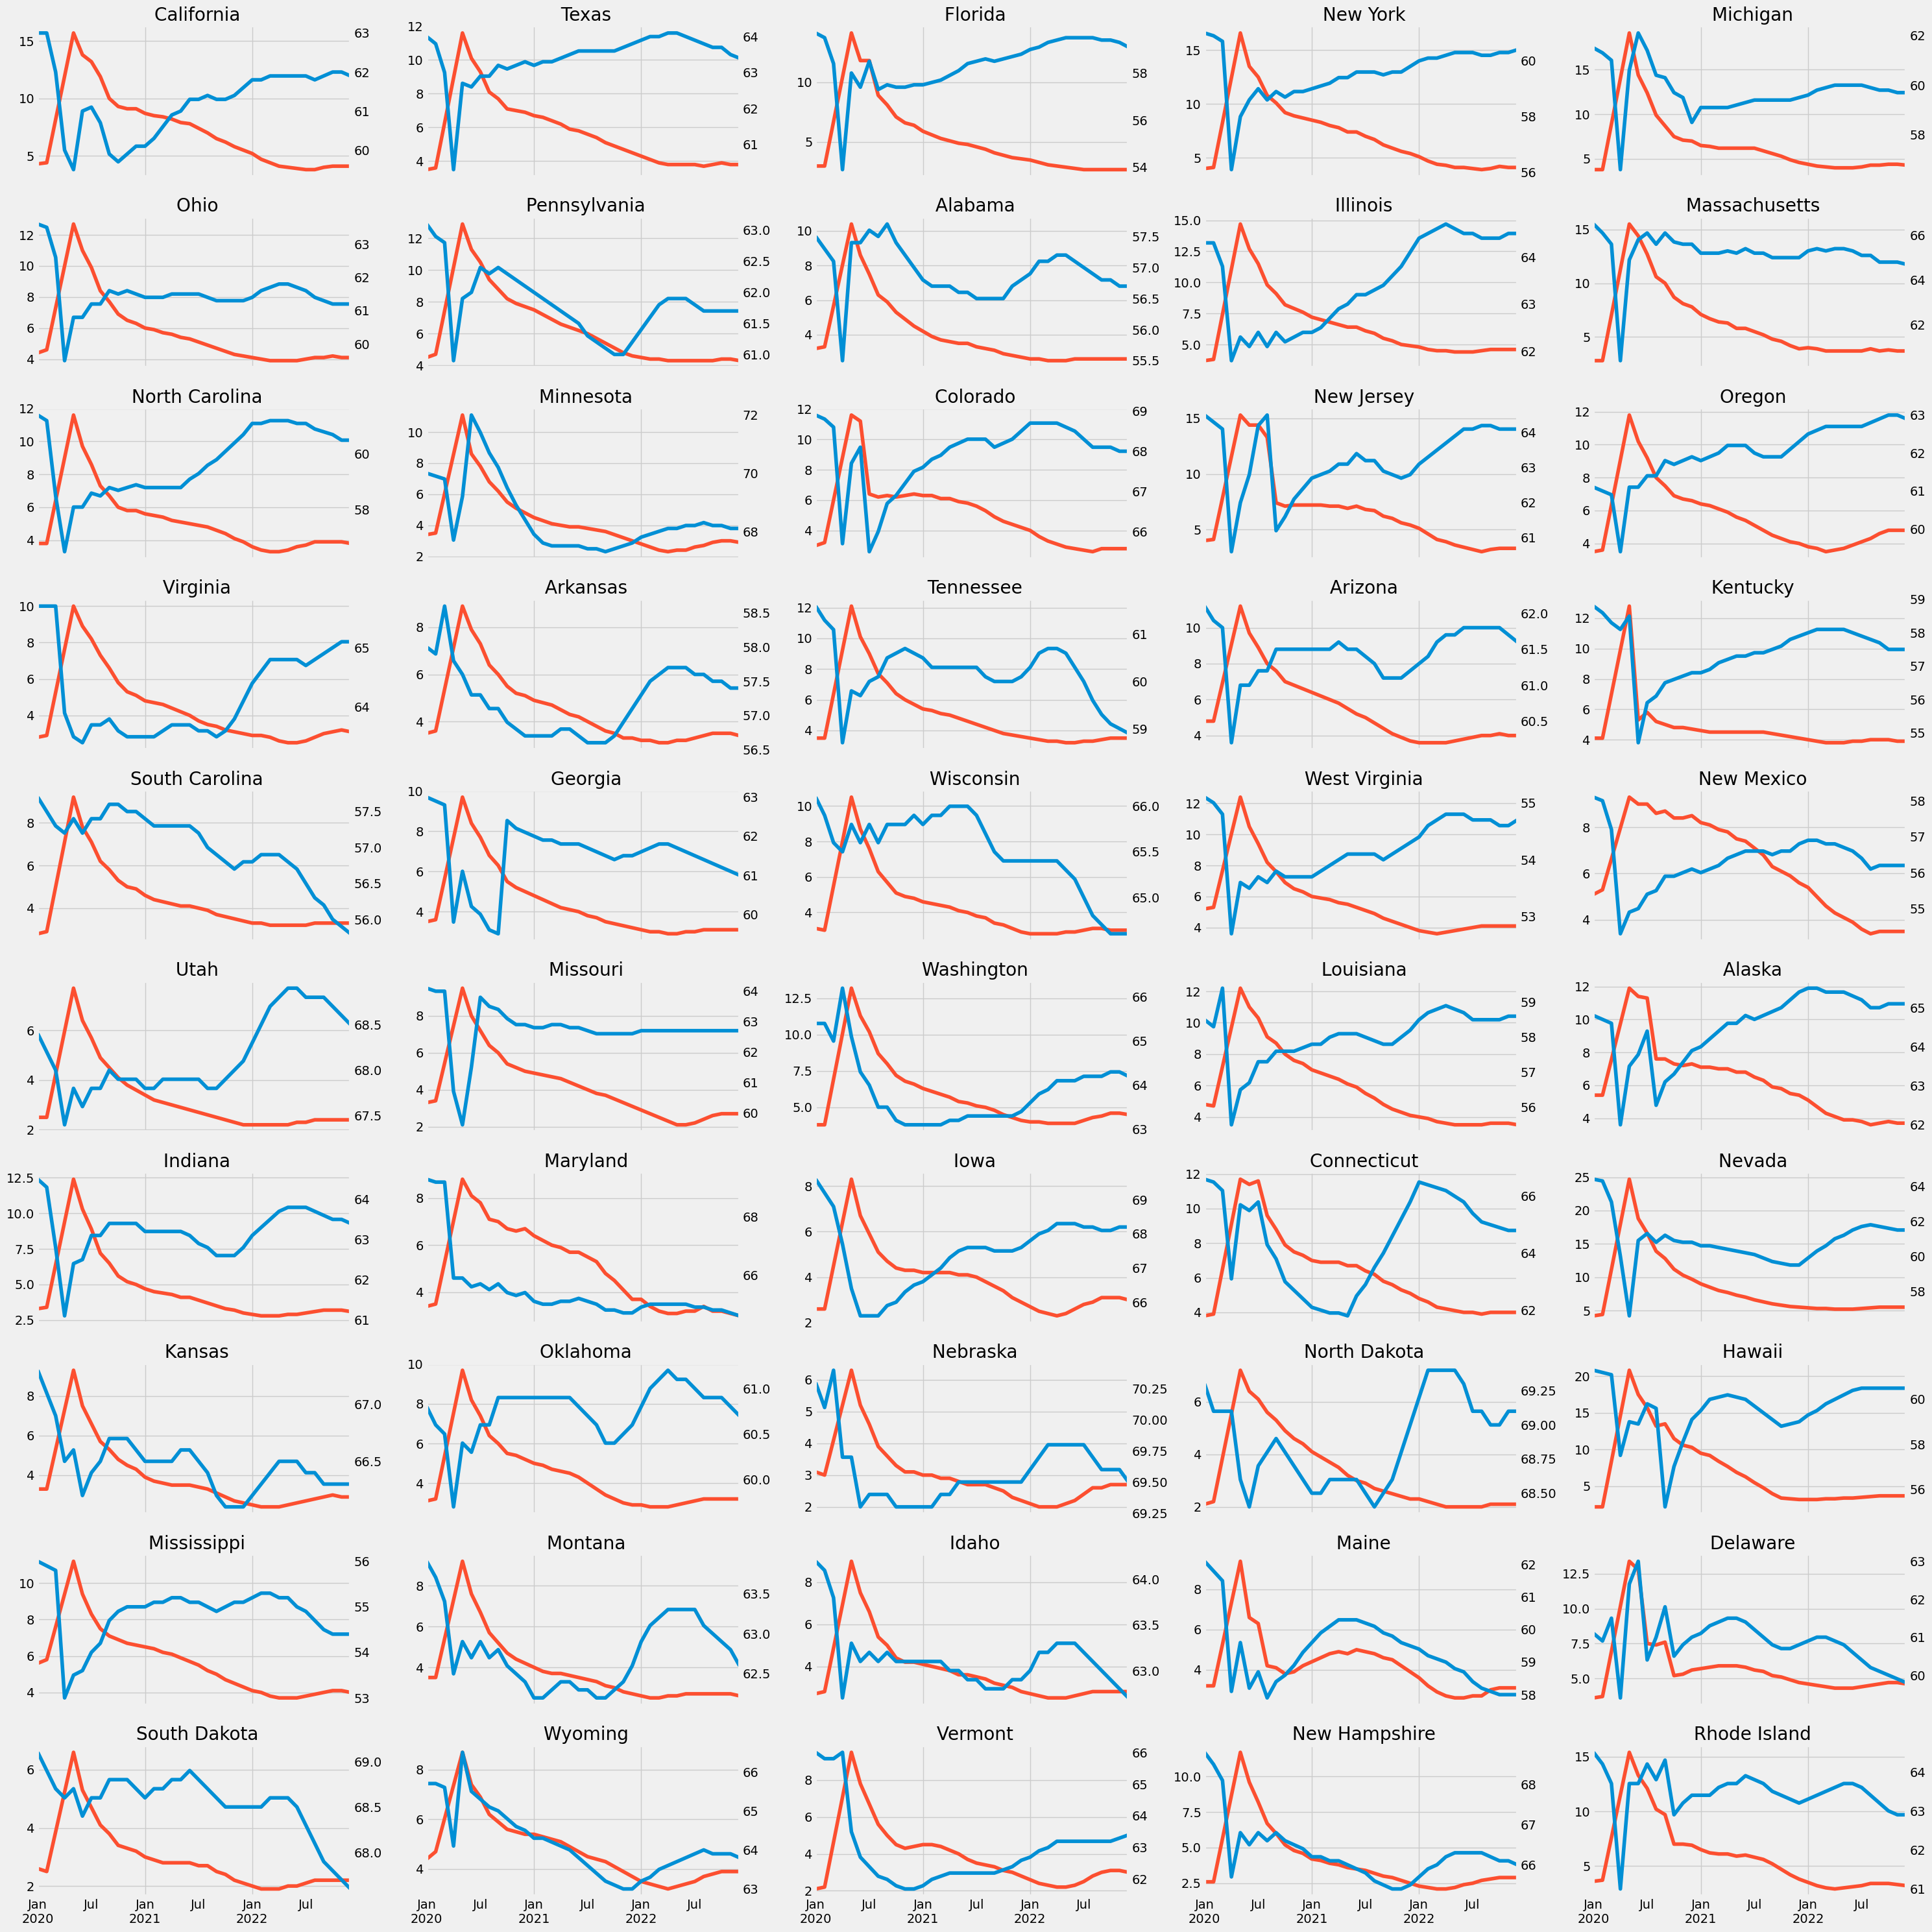

In [16]:
fig, axs = plt.subplots(10,5, figsize=(30,30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemploymnet_states.columns:
    if state == ' District of Columbia':
        continue
    ax2 = axs[i].twinx()
    part_states.query('index >= 2020 and index < 2023')[state].plot(ax=ax2, label="Participation")
    unemploymnet_states.query('index >= 2020 and index < 2023')[state].plot(ax=axs[i], label="Unemployment", color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()